In [24]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.metrics import f1_score, roc_auc_score, brier_score_loss
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import scipy
from scipy.stats import kstest, ttest_ind, ks_2samp, mannwhitneyu, mode
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Loading the Data

In [26]:
SEED = 42
REPEATS = 5
FOLDS = 5

train_q = pd.read_excel("Dataset/widsdatathon2025/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx")
train_c = pd.read_excel("Dataset/widsdatathon2025/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx")
test_q = pd.read_excel("Dataset/widsdatathon2025/TEST/TEST_QUANTITATIVE_METADATA.xlsx")
test_c = pd.read_excel("Dataset/widsdatathon2025/TEST/TEST_CATEGORICAL.xlsx")

train_combined = pd.merge(train_q, train_c, on="participant_id", how="left").set_index("participant_id")
test_combined = pd.merge(test_q, test_c, on="participant_id", how="left").set_index("participant_id")

labels = pd.read_excel("Dataset/widsdatathon2025/TRAIN/TRAINING_SOLUTIONS.xlsx").set_index("participant_id")
assert all(train_combined.index == labels.index), "Label IDs don't match train IDs"

# Preprocessing

In [28]:
# Drop columns 
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity",
    "PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
]
train_combined.drop(drop_cols, axis=1, inplace=True)
test_combined.drop(drop_cols, axis=1, inplace=True)

# Standardize features
scaler = StandardScaler()
train_combined = pd.DataFrame(
    scaler.fit_transform(train_combined), columns=train_combined.columns, index=train_combined.index
)
test_combined = pd.DataFrame(
    scaler.transform(test_combined), columns=test_combined.columns, index=test_combined.index
)

# Impute missing values using IterativeImputer with Lasso
imputer = IterativeImputer(estimator=LassoCV(random_state=SEED), max_iter=5, random_state=SEED)
train_combined[:] = imputer.fit_transform(train_combined)
test_combined[:] = imputer.transform(test_combined)

# Retrieve targets
y_adhd = labels["ADHD_Outcome"]
y_sex = labels["Sex_F"]
# ADHD&Sex Combinations to stratify on
combinations = labels["ADHD_Outcome"].astype(str) + labels["Sex_F"].astype(str)

# Model Evaluation

In [30]:
features_sex = [
       'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu'
]

features_adhd = [
       'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P2_Edu', 'sex_proba',
       'I_APQ_P_APQ_P_INV', 'I_APQ_P_APQ_P_PP', 'I_SDQ_SDQ_Hyperactivity',
       'I_MRI_Track_Age_at_Scan', 'I_SDQ_SDQ_Generating_Impact'
]

# Features to be interacted with predicted probability of Sex_F = 1
interactions = [
    "APQ_P_APQ_P_INV", "APQ_P_APQ_P_PP", "SDQ_SDQ_Hyperactivity", 
    "MRI_Track_Age_at_Scan", "SDQ_SDQ_Generating_Impact"
]

In [31]:
def eval_metrics(y_true, y_pred, weights, label="None", thresh=0.5):
    """Evaluate predictions using Brier Score and F1 Score."""
    brier = brier_score_loss(y_true, y_pred)
    f1 = f1_score(y_true, (y_pred > thresh).astype(int), sample_weight=weights)
    print(f"{label} -> Brier Score: {brier:.4f}, F1: {f1:.4f}")
    return brier, f1

# store oof brier and f1
scores_sex = []
scores_adhd = []

# store oof predictions for diagnostics and threshold optimization
sex_oof = np.zeros(len(y_sex))
adhd_oof = np.zeros(len(y_adhd))

# classification thresholds
t_sex = 0.3
t_adhd = 0.4

# Repeated Stratified K-Fold
rskf = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS, random_state=SEED)
# skf for LogisticRegressionCV
skf = StratifiedKFold(n_splits=FOLDS)

params_1 = {
    "penalty":"l1", 
    "Cs": 10, 
    "cv":skf, 
    "fit_intercept":True, 
    "scoring": "f1", 
    "random_state": SEED, 
    "solver": "saga"
}

params_2 = {
    "penalty":"l1", 
    "Cs": 10, 
    "cv":skf, 
    "fit_intercept":True, 
    "scoring": "f1", 
    "random_state": SEED, 
    "solver": "saga"
}

model_1 = LogisticRegressionCV(**params_1)
model_2 = LogisticRegressionCV(**params_2)

for fold, (train_idx, val_idx) in enumerate(rskf.split(train_combined, combinations), 1):
    print(f"\n=== Fold {fold} ===")

    # Split data
    X_train, X_val = train_combined.iloc[train_idx], train_combined.iloc[val_idx]
    y_train_adhd, y_val_adhd = y_adhd.iloc[train_idx], y_adhd.iloc[val_idx]
    y_train_sex, y_val_sex = y_sex.iloc[train_idx], y_sex.iloc[val_idx]
    # 2x weight for Sex_F == 1 and ADHD_Outcome == 1 (as mentioned in competition evaluation)
    weights_train = np.where(combinations.iloc[train_idx]=="11", 2, 1)
    weights = np.where(combinations.iloc[val_idx]=="11", 2, 1)

    # ----------------
    # Sex_F prediction
    # ----------------
    # Model 1
    model_1.fit(X_train[features_sex], y_train_sex, sample_weight=weights_train)
    sex_train = model_1.predict_proba(X_train[features_sex])[:, 1]
    sex_val = model_1.predict_proba(X_val[features_sex])[:, 1]
    sex_oof[val_idx] += sex_val / REPEATS

    sex_brier, sex_f1 = eval_metrics(y_val_sex, sex_val, weights, "Sex_F", thresh=t_sex)
    scores_sex.append((sex_brier, sex_f1))

    # ----------------
    # Outcome_ADHD prediction
    # ----------------
    # Add predicted proba from previous model
    X_train["sex_proba"] = sex_train
    X_val["sex_proba"] = sex_val

    # adding interactions between predicted sex and other features
    for interaction in interactions:
        X_train[f"I_{interaction}"] = X_train[interaction] * X_train["sex_proba"]
        X_val[f"I_{interaction}"] = X_val[interaction] * X_val["sex_proba"]

    # Logistic Regression with L1 penalty
    model_2.fit(X_train[features_adhd], y_train_adhd, sample_weight=weights_train)
    
    adhd_val = model_2.predict_proba(X_val[features_adhd])[:, 1]
    adhd_oof[val_idx] += adhd_val / REPEATS
    
    adhd_brier, adhd_f1 = eval_metrics(y_val_adhd, adhd_val, weights, "Outcome ADHD", thresh=t_adhd)
    scores_adhd.append((adhd_brier, adhd_f1))

print(f"\n=== CV Results ===")
print(f"Sex Mean Brier Score: {np.mean([s[0] for s in scores_sex]):.4f}")
print(f"Sex Mean F1: {np.mean([s[1] for s in scores_sex]):.4f}")
print(f"ADHD Mean Brier Score: {np.mean([s[0] for s in scores_adhd]):.4f}")
print(f"ADHD Mean F1: {np.mean([s[1] for s in scores_adhd]):.4f}")


=== Fold 1 ===
Sex_F -> Brier Score: 0.2224, F1: 0.6324
Outcome ADHD -> Brier Score: 0.1415, F1: 0.8903

=== Fold 2 ===
Sex_F -> Brier Score: 0.2152, F1: 0.6189
Outcome ADHD -> Brier Score: 0.1387, F1: 0.8903

=== Fold 3 ===
Sex_F -> Brier Score: 0.2338, F1: 0.6247
Outcome ADHD -> Brier Score: 0.1647, F1: 0.8701

=== Fold 4 ===
Sex_F -> Brier Score: 0.2258, F1: 0.6269
Outcome ADHD -> Brier Score: 0.1448, F1: 0.8898

=== Fold 5 ===
Sex_F -> Brier Score: 0.2324, F1: 0.6427
Outcome ADHD -> Brier Score: 0.1249, F1: 0.8843

=== Fold 6 ===
Sex_F -> Brier Score: 0.2314, F1: 0.6272
Outcome ADHD -> Brier Score: 0.1451, F1: 0.8865

=== Fold 7 ===
Sex_F -> Brier Score: 0.2252, F1: 0.6219
Outcome ADHD -> Brier Score: 0.1557, F1: 0.8798

=== Fold 8 ===
Sex_F -> Brier Score: 0.2366, F1: 0.5969
Outcome ADHD -> Brier Score: 0.1468, F1: 0.8785

=== Fold 9 ===
Sex_F -> Brier Score: 0.2281, F1: 0.6218
Outcome ADHD -> Brier Score: 0.1331, F1: 0.8846

=== Fold 10 ===
Sex_F -> Brier Score: 0.2115, F1: 0.63

# Threshold Optimization

ADHD Thresholds: 100%|██████████| 100/100 [00:00<00:00, 1378.19it/s]


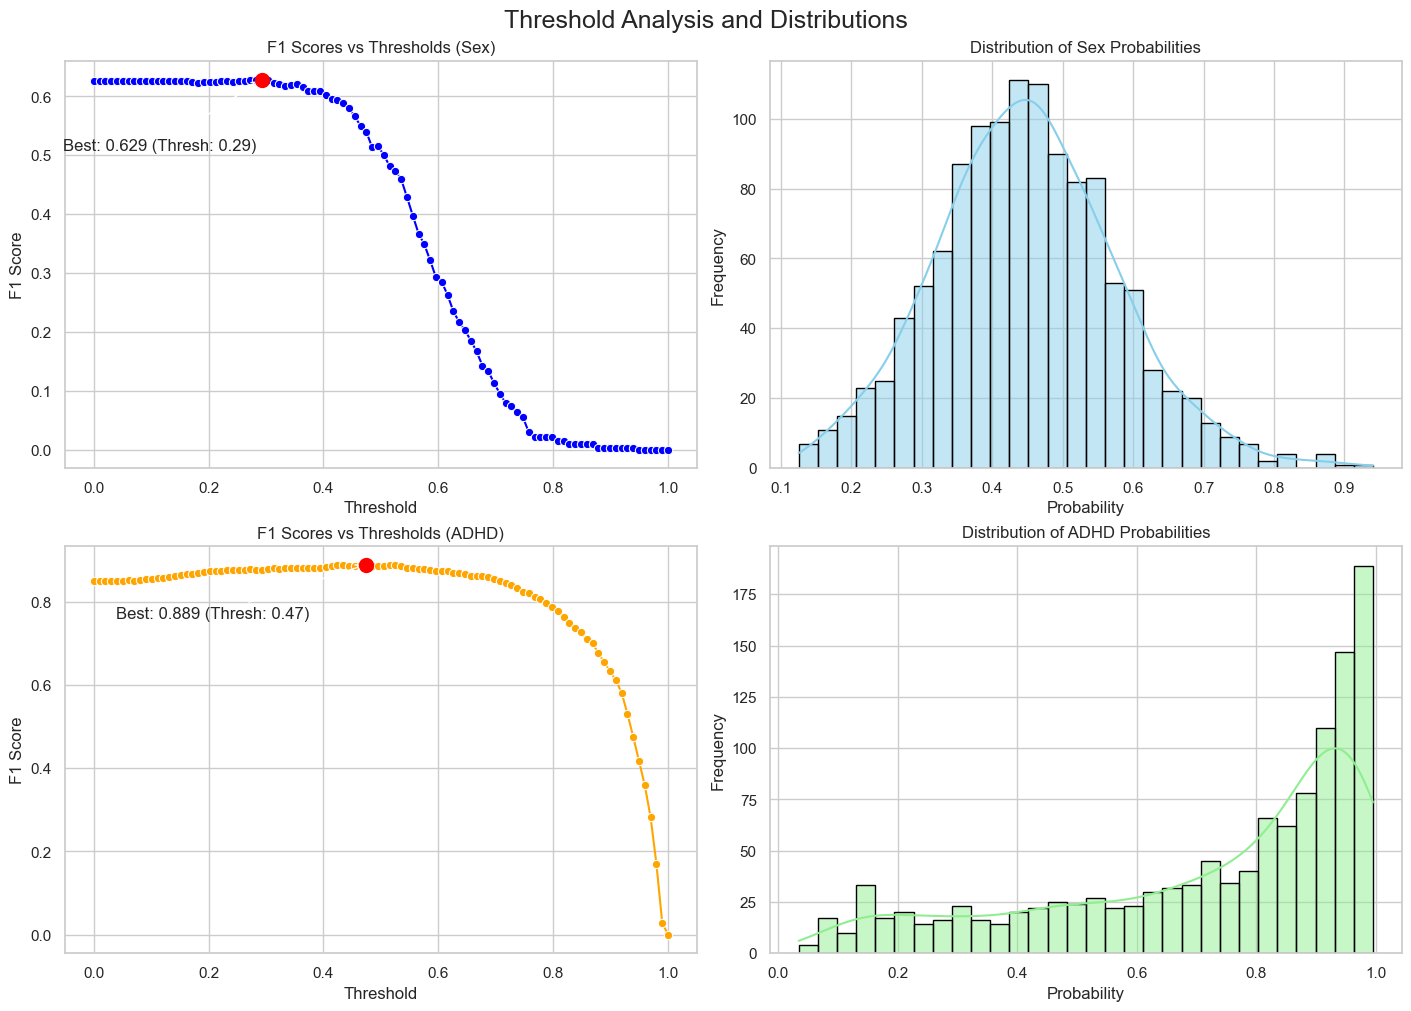

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from tqdm import tqdm

# Replace these with your actual prediction arrays.
# For example purposes, these lines create dummy data:
np.random.seed(42)

sex_prob = sex_oof
adhd_prob = adhd_oof

# Compute sample weights: example weight increases if both conditions are true
weights = ((y_adhd == 1) & (y_sex == 1)) + 1

# Define thresholds to test
thresholds = np.linspace(0, 1, 100)

# Compute F1 scores and determine the best threshold for Sex predictions
sex_scores = []
for t in tqdm(thresholds, desc="Sex Thresholds"):
    tmp_pred = np.where(sex_prob > t, 1, 0)
    tmp_score = f1_score(y_sex, tmp_pred, sample_weight=weights)
    sex_scores.append(tmp_score)
best_sex_threshold = thresholds[np.argmax(sex_scores)]
best_sex_score = max(sex_scores)

# Compute F1 scores and determine the best threshold for ADHD predictions
adhd_scores = []
for t in tqdm(thresholds, desc="ADHD Thresholds"):
    tmp_pred = np.where(adhd_prob > t, 1, 0)
    tmp_score = f1_score(y_adhd, tmp_pred, sample_weight=weights)
    adhd_scores.append(tmp_score)
best_adhd_threshold = thresholds[np.argmax(adhd_scores)]
best_adhd_score = max(adhd_scores)

# Set seaborn theme for better aesthetics
sns.set_theme(style="whitegrid")

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

# Plot F1 scores vs. thresholds for Sex predictions using seaborn's lineplot
sns.lineplot(x=thresholds, y=sex_scores, ax=axs[0, 0], marker="o", color="blue")
axs[0, 0].scatter(best_sex_threshold, best_sex_score, color='red', s=100, zorder=5)
axs[0, 0].set_title('F1 Scores vs Thresholds (Sex)')
axs[0, 0].set_xlabel('Threshold')
axs[0, 0].set_ylabel('F1 Score')

# Annotate the best threshold point
axs[0, 0].annotate(f'Best: {best_sex_score:.3f} (Thresh: {best_sex_threshold:.2f})',
                   xy=(best_sex_threshold, best_sex_score),
                   xytext=(best_sex_threshold - 0.01, best_sex_score - 0.1),  # Adjust left and down
                   arrowprops=dict(facecolor='black', arrowstyle='->'),
                   ha='right', va='top')

# Plot histogram (with KDE) of Sex predicted probabilities
sns.histplot(sex_prob, bins=30, ax=axs[0, 1], kde=True, color="skyblue", edgecolor='black')
axs[0, 1].set_title('Distribution of Sex Probabilities')
axs[0, 1].set_xlabel('Probability')
axs[0, 1].set_ylabel('Frequency')

# Plot F1 scores vs. thresholds for ADHD predictions using seaborn's lineplot
sns.lineplot(x=thresholds, y=adhd_scores, ax=axs[1, 0], marker="o", color="orange")
axs[1, 0].scatter(best_adhd_threshold, best_adhd_score, color='red', s=100, zorder=5)
axs[1, 0].set_title('F1 Scores vs Thresholds (ADHD)')
axs[1, 0].set_xlabel('Threshold')
axs[1, 0].set_ylabel('F1 Score')
# Annotate the best threshold point
axs[1, 0].annotate(f'Best: {best_adhd_score:.3f} (Thresh: {best_adhd_threshold:.2f})',
                   xy=(best_adhd_threshold, best_adhd_score),
                   xytext=(best_adhd_threshold - 0.1, best_adhd_score - 0.1),  # Adjust left and down
                   arrowprops=dict(facecolor='black', arrowstyle='->'),
                   ha='right', va='top')

# Plot histogram (with KDE) of ADHD predicted probabilities
sns.histplot(adhd_prob, bins=30, ax=axs[1, 1], kde=True, color="lightgreen", edgecolor='black')
axs[1, 1].set_title('Distribution of ADHD Probabilities')
axs[1, 1].set_xlabel('Probability')
axs[1, 1].set_ylabel('Frequency')

plt.suptitle('Threshold Analysis and Distributions', fontsize=18)
plt.show()


# Final Model& Predictions

In [35]:
# Final models and predictions
model_1.fit(train_combined[features_sex], y_sex, sample_weight=weights)

sex_proba_train = model_1.predict_proba(train_combined[features_sex])[:,1]
sex_proba_test = model_1.predict_proba(test_combined[features_sex])[:,1]

train_combined["sex_proba"] = sex_proba_train
test_combined["sex_proba"] = sex_proba_test

for interaction in interactions:
    train_combined[f"I_{interaction}"] = train_combined["sex_proba"] * train_combined[interaction]
    test_combined[f"I_{interaction}"] = test_combined["sex_proba"] * test_combined[interaction]

model_2.fit(train_combined[features_adhd], y_adhd, sample_weight=weights)

adhd_proba_test = model_2.predict_proba(test_combined[features_adhd])[:,1]
# Show most important features for model 1 
coeffs_1 = pd.DataFrame({"feature": features_sex, "coeff": model_1.coef_[0]})
coeffs_1.sort_values(by="coeff", key=abs, ascending=False)[:15]

,feature,coeff
10,SDQ_SDQ_Emotional_Problems,0.340671
13,SDQ_SDQ_Hyperactivity,-0.234141
16,SDQ_SDQ_Prosocial,0.222132
17,MRI_Track_Age_at_Scan,-0.220319
1,ColorVision_CV_Score,0.200008
4,APQ_P_APQ_P_INV,-0.153001
18,Barratt_Barratt_P1_Edu,0.133269
12,SDQ_SDQ_Generating_Impact,0.102562
6,APQ_P_APQ_P_PM,0.090632
11,SDQ_SDQ_Externalizing,-0.078626


In [36]:
# Final models and predictions
model_1.fit(train_combined[features_sex], y_sex, sample_weight=weights)

sex_proba_train = model_1.predict_proba(train_combined[features_sex])[:,1]
sex_proba_test = model_1.predict_proba(test_combined[features_sex])[:,1]

train_combined["sex_proba"] = sex_proba_train
test_combined["sex_proba"] = sex_proba_test

for interaction in interactions:
    train_combined[f"I_{interaction}"] = train_combined["sex_proba"] * train_combined[interaction]
    test_combined[f"I_{interaction}"] = test_combined["sex_proba"] * test_combined[interaction]

model_2.fit(train_combined[features_adhd], y_adhd, sample_weight=weights)

adhd_proba_test = model_2.predict_proba(test_combined[features_adhd])[:,1]
# Show most important features for model 2 
coeffs_2 = pd.DataFrame({"feature": features_adhd, "coeff": model_2.coef_[0]})
coeffs_2.sort_values(by="coeff", key=abs, ascending=False)[:15]

,feature,coeff
22,I_APQ_P_APQ_P_PP,-1.845562
23,I_SDQ_SDQ_Hyperactivity,1.684995
21,I_APQ_P_APQ_P_INV,1.191189
7,APQ_P_APQ_P_PP,0.958604
24,I_MRI_Track_Age_at_Scan,0.946566
13,SDQ_SDQ_Hyperactivity,0.721768
4,APQ_P_APQ_P_INV,-0.648664
12,SDQ_SDQ_Generating_Impact,0.598637
25,I_SDQ_SDQ_Generating_Impact,-0.442054
2,APQ_P_APQ_P_CP,-0.181504


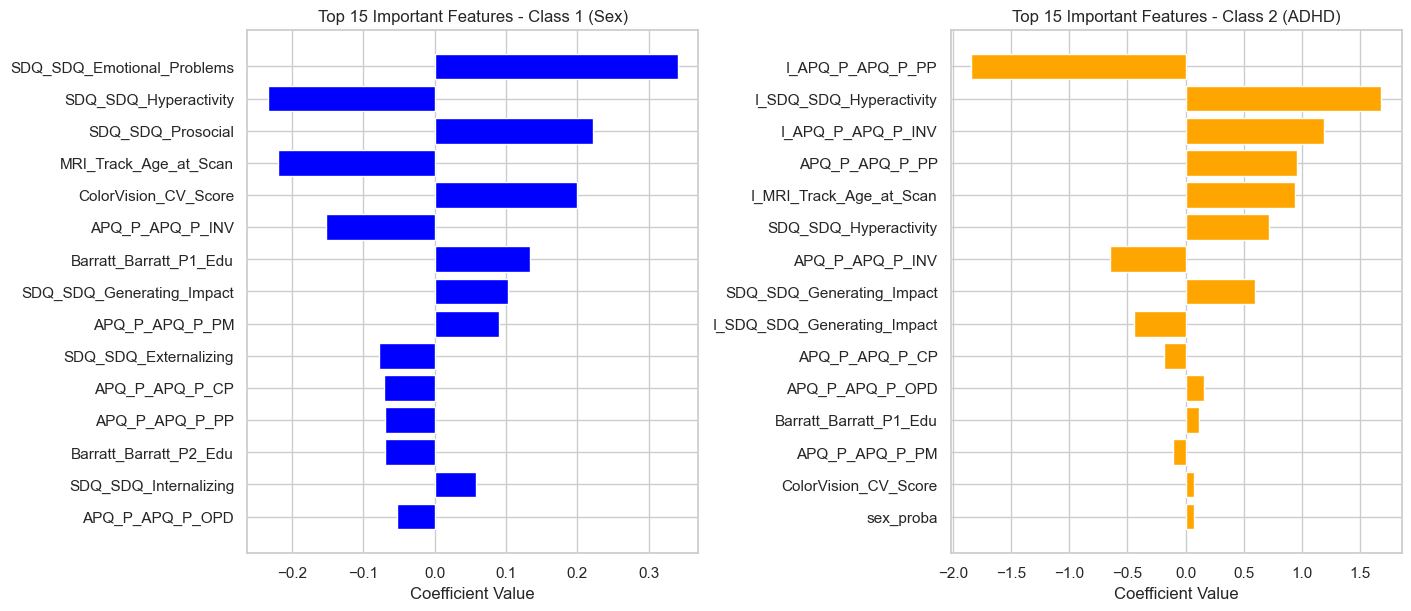

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Sort the coefficients by absolute value for both models
top_features_sex = coeffs_1.sort_values(by="coeff", key=abs, ascending=False)[:15]
top_features_adhd = coeffs_2.sort_values(by="coeff", key=abs, ascending=False)[:15]

# Create subplots for better visualization
fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Plot the most important features for model 1 (Sex)
axs[0].barh(top_features_sex["feature"], top_features_sex["coeff"], color="blue")
axs[0].set_title("Top 15 Important Features - Class 1 (Sex)")
axs[0].set_xlabel("Coefficient Value")
axs[0].invert_yaxis()  # Ensures the most important feature is on top

# Plot the most important features for model 2 (ADHD)
axs[1].barh(top_features_adhd["feature"], top_features_adhd["coeff"], color="orange")
axs[1].set_title("Top 15 Important Features - Class 2 (ADHD)")
axs[1].set_xlabel("Coefficient Value")
axs[1].invert_yaxis()

# Display the plot
plt.show()

# Sanity Checks& Submission

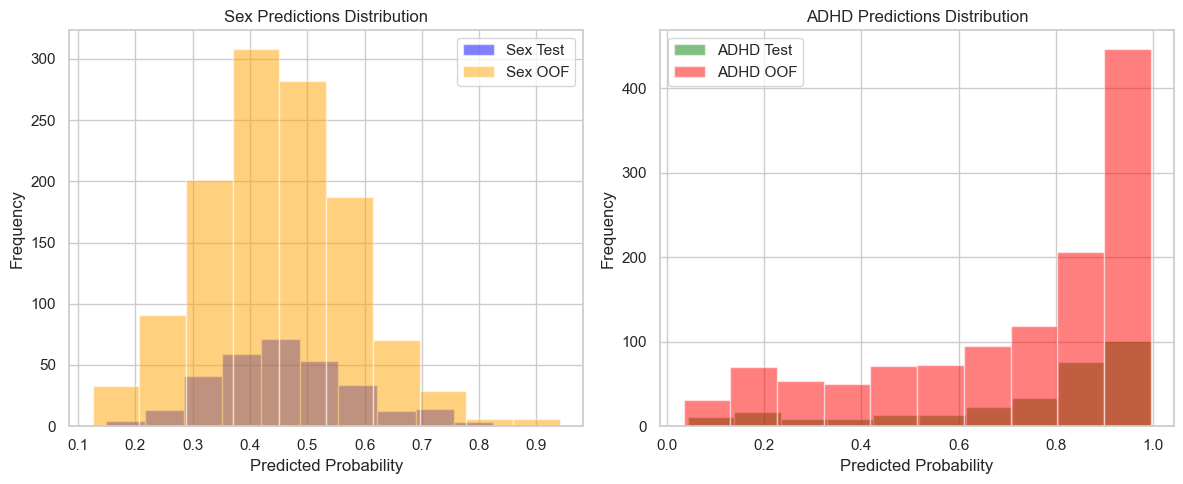

Kolmogorov-Smirnov Test and MannWhitneyU Results:
Sex KS Test vs. OOF: Statistic=0.0617, p-value=0.2983
Sex MWU Test vs. OOF: Statistic=191604.0000, p-value=0.2900
ADHD KS Test vs. OOF: Statistic=0.0651, p-value=0.2418
ADHD MWU Test vs. OOF: Statistic=188398.0000, p-value=0.5560
Share ADHD OOF: 0.7980 - Share ADHD Test: 0.8355
Share Sex_F OOF: 0.8904 - Share Sex_F Test: 0.9342


In [39]:
# Plotting distributions with improved visuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot for Sex predictions
ax[0].hist(sex_proba_test, bins=10, alpha=0.5, color='blue', label='Sex Test')
ax[0].hist(sex_oof, bins=10, alpha=0.5, color='orange', label='Sex OOF')
ax[0].set_title('Sex Predictions Distribution')
ax[0].set_xlabel('Predicted Probability')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Plot for ADHD predictions
ax[1].hist(adhd_proba_test, bins=10, alpha=0.5, color='green', label='ADHD Test')
ax[1].hist(adhd_oof, bins=10, alpha=0.5, color='red', label='ADHD OOF')
ax[1].set_title('ADHD Predictions Distribution')
ax[1].set_xlabel('Predicted Probability')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.tight_layout()
plt.show()

# Statistical test to compare distributions
sex_test_result = ks_2samp(sex_proba_test, sex_oof)
adhd_test_result = ks_2samp(adhd_proba_test, adhd_oof)
sex_mwu_result = mannwhitneyu(sex_proba_test, sex_oof)
adhd_mwu_result = mannwhitneyu(adhd_proba_test, adhd_oof)

print("Kolmogorov-Smirnov Test and MannWhitneyU Results:")
print(f"Sex KS Test vs. OOF: Statistic={sex_test_result.statistic:.4f}, p-value={sex_test_result.pvalue:.4f}")
print(f"Sex MWU Test vs. OOF: Statistic={sex_mwu_result.statistic:.4f}, p-value={sex_mwu_result.pvalue:.4f}")
print(f"ADHD KS Test vs. OOF: Statistic={adhd_test_result.statistic:.4f}, p-value={adhd_test_result.pvalue:.4f}")
print(f"ADHD MWU Test vs. OOF: Statistic={adhd_mwu_result.statistic:.4f}, p-value={adhd_mwu_result.pvalue:.4f}")

# Submission
submission = pd.read_excel("Dataset/widsdatathon2025/SAMPLE_SUBMISSION.xlsx")
submission["ADHD_Outcome"] = np.where(adhd_proba_test > best_adhd_threshold, 1, 0)
submission["Sex_F"] = np.where(sex_proba_test > best_sex_threshold, 1, 0)
# Compare share of predicted labels at thresholds between OOF and Test
print(f"Share ADHD OOF: {np.mean(np.where(adhd_oof > best_adhd_threshold, 1, 0)):.4f} - Share ADHD Test: {submission.ADHD_Outcome.mean():.4f}")
print(f"Share Sex_F OOF: {np.mean(np.where(sex_oof > best_sex_threshold, 1, 0)):.4f} - Share Sex_F Test: {submission.Sex_F.mean():.4f}")

In [40]:
submission.to_csv("saved_models/submission_v17.csv", index=False)